In [1]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns


## Data preparation
#### Some data cleaning and merging was done using scripts: `get_data.py` and `clean_data.py`
 

In [10]:
#'### Read the data. Filling up missing values with 0
df=pd.read_csv("weather_data/ikermit.csv")
df.fillna(0)

,TempDry,date,TempDew,TempMeanPast1h,TempMaxPast1h,TempMinPast1h,Humidity,HumidityPast1h,Pressure,PressureAtSea,...,WindSpeedPast1h,WindGustAlwaysPast1h,WindMax,WindMinPast1h,WindMin,PrecipPast1h,PrecipDurPast1h,Visibility,Weather,LeavHumDurPast1h
0,8.5,2021-12-31T00:00:00Z,8.5,8.2,8.5,8.1,100.0,100.0,1005.2,1006.5,...,4.6,8.5,8.5,0.0,0.0,0.2,1.0,8000.0,110.0,0.0
1,8.3,2021-12-30T23:50:00Z,8.3,0.0,0.0,0.0,100.0,0.0,1005.3,1006.6,...,0.0,0.0,8.2,0.0,0.0,0.0,0.0,6000.0,110.0,0.0
2,8.3,2021-12-30T23:40:00Z,8.2,0.0,0.0,0.0,100.0,0.0,1005.5,1006.7,...,0.0,0.0,8.2,0.0,0.0,0.0,0.0,5000.0,110.0,0.0
3,8.2,2021-12-30T23:30:00Z,8.2,0.0,0.0,0.0,100.0,0.0,1005.6,1006.8,...,0.0,0.0,7.9,0.0,0.0,0.0,0.0,4200.0,110.0,0.0
4,8.2,2021-12-30T23:20:00Z,8.2,0.0,0.0,0.0,100.0,0.0,1005.5,1006.8,...,0.0,0.0,7.3,0.0,0.0,0.0,0.0,3700.0,110.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390161,2.1,2020-01-01T00:40:00Z,1.1,0.0,0.0,0.0,93.0,0.0,1028.1,1029.4,...,0.0,0.0,4.8,0.0,0.0,0.0,0.0,2600.0,110.0,0.0
390162,2.1,2020-01-01T00:30:00Z,1.2,0.0,0.0,0.0,94.0,0.0,1028.1,1029.4,...,0.0,0.0,5.1,0.0,0.0,0.0,0.0,1800.0,110.0,0.0
390163,1.9,2020-01-01T00:20:00Z,0.9,0.0,0.0,0.0,93.0,0.0,1028.2,1029.5,...,0.0,0.0,3.2,0.0,0.0,0.0,0.0,1700.0,110.0,0.0
390164,2.0,2020-01-01T00:10:00Z,0.8,0.0,0.0,0.0,92.0,0.0,1028.2,1029.4,...,0.0,0.0,2.8,0.0,0.0,0.0,0.0,1600.0,110.0,0.0


In [11]:
print(df.columns)


Index(['TempDry', 'date', 'TempDew', 'TempMeanPast1h', 'TempMaxPast1h',
       'TempMinPast1h', 'Humidity', 'HumidityPast1h', 'Pressure',
       'PressureAtSea', 'WindDir', 'WindDirPast1h', 'WindSpeed',
       'WindSpeedPast1h', 'WindGustAlwaysPast1h', 'WindMax', 'WindMinPast1h',
       'WindMin', 'PrecipPast1h', 'PrecipDurPast1h', 'Visibility', 'Weather',
       'LeavHumDurPast1h'],
      dtype='object')


In [13]:
## Checking possible correlations below

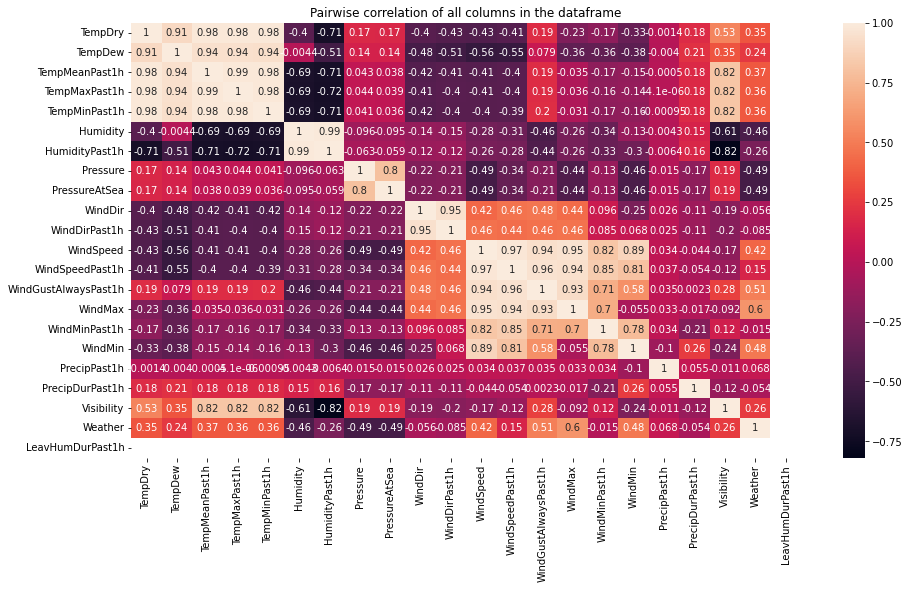

In [14]:
plt.figure(figsize=(15,8))
sns.heatmap(data= df.corr(), annot=True)
plt.title("Pairwise correlation of all columns in the dataframe")
# save the figure
#plt.savefig('corr.png', dpi=300, bbox_inches='tight')
plt.show()

### Dropping some variables
WindDir (wind direction) will be ignored and dropped from the list, since it 
it follows circular statistics (it might be confusing to use with other scalar variables)

LeavHumDurPast1h is obviously very empty ("Number of minutes with leaf moisture in the latest 10 minutes"). 
It does not seem relevant.

Weather is an indication of the weather state, and it has a range of values ranging from 0 to 190 or so.


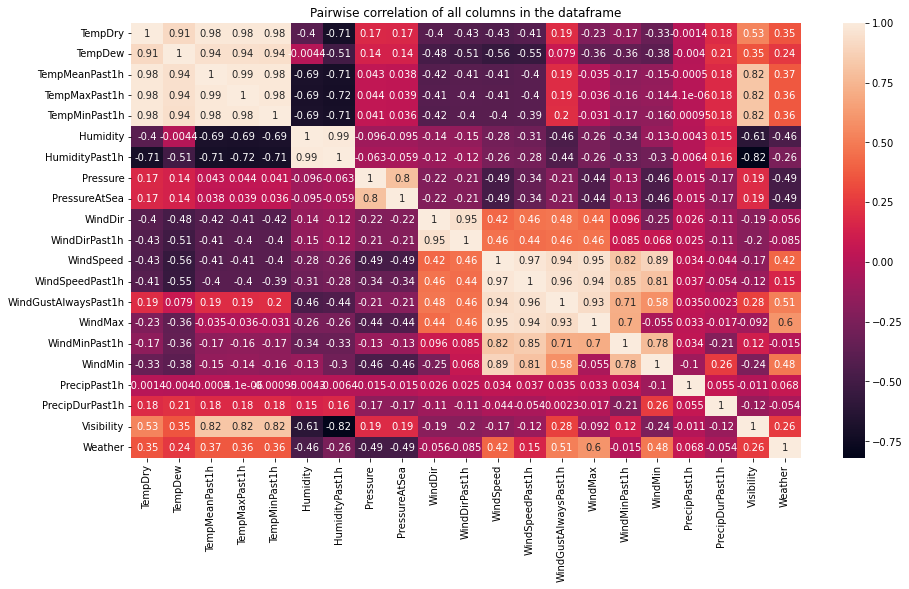

In [15]:
df.drop(columns=["LeavHumDurPast1h"],inplace=True)
plt.figure(figsize=(15,8))
sns.heatmap(data= df.corr(), annot=True)
plt.title("Pairwise correlation of all columns in the dataframe")
# save the figure
#plt.savefig('corr.png', dpi=300, bbox_inches='tight')
plt.show()

<AxesSubplot:xlabel='Weather', ylabel='Count'>

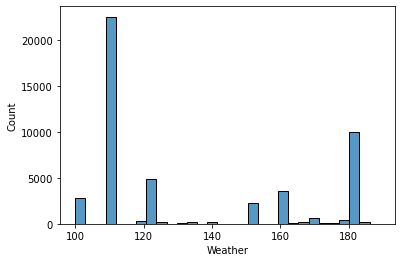

In [16]:
sns.histplot(df.Weather, bins=30)

<AxesSubplot:xlabel='TempDry', ylabel='Count'>

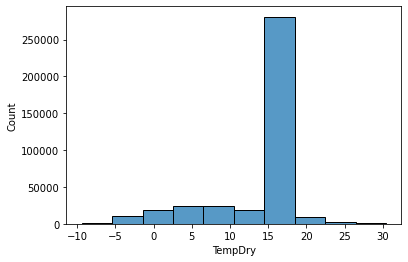

In [17]:
sns.histplot(df['TempDry'], bins=10)

Data has following units

Wind: 
Precip: 
Temp: 
Humidity: %

Do some unit conversions below

<AxesSubplot:xlabel='WindSpeed', ylabel='Count'>

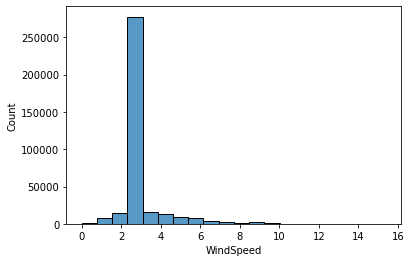

In [19]:
sns.histplot(df.WindSpeed, bins=20)

<AxesSubplot:xlabel='PrecipPast1h', ylabel='Count'>

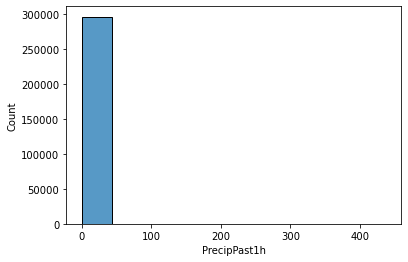

In [20]:
sns.histplot(df.PrecipPast1h, bins=10)

Determine storm categories

Five	≥ 70 m/s  	≥ 137 kn  	≥ 157 mph  	≥ 252 km/h  
Four	  58–70 m/s  	  113–136 kn  	  130–156 mph  	  209–251 km/h  
Three	  50–58 m/s  	  96–112 kn  	  111–129 mph  	  178–208 km/h  
Two	  43–49 m/s  	  83–95 kn  	  96–110 mph  	  154–177 km/h  
One	

In [ ]:
storm_cats={"one": {"min":33, "max":42},
            "two": {"min":43, "max":49 }
             "three"}# in m/s